# **Classification of dementia stages caused by Alzheimer’s Disease**

Segmented T1 MR images

**Dependencies :**

In [27]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets 
import numpy as np
from PIL import Image
import os
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Model Architecture :**

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.Conv1=nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=0) 
        self.Conv2=nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.Conv3=nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0)
        self.Conv4=nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=0)
        self.Matrix1=nn.Linear(16*11*9,512) 
        self.Matrix2=nn.Linear(512,4)
        self.Pool=nn.MaxPool2d(kernel_size=2, stride=2) 
        self.R=nn.ReLU()
        self.dropout=nn.Dropout(0.7)
        self.batch1=nn.BatchNorm2d(128)
        self.batch2=nn.BatchNorm2d(64)
        self.batch3=nn.BatchNorm2d(32)
        self.batch4=nn.BatchNorm2d(16)
    def forward(self, x):
        x=self.Pool(self.R(self.batch1(self.Conv1(x))))
        x=self.Pool(self.R(self.batch2(self.Conv2(x))))
        x=self.Pool(self.R(self.batch3(self.Conv3(x))))
        x=self.Pool(self.R(self.batch4(self.Conv4(x))))
        x=self.dropout(x)
        x=x.view(-1,16*11*9)
        x=self.R(self.Matrix1(x))
        x=self.Matrix2(x)
        return x


model=CNN().to(device)

**Total number of trainable parameters :**

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of trainable parameters: {count_parameters(model)}')

Number of trainable parameters: 912212


# First Training Stategy :

**Data Processing and Augmentation :**

In [29]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=10)
    ],p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=350)
    ],p=0.5),
    transforms.RandomAutocontrast(p=1),
    transforms.RandomAdjustSharpness(sharpness_factor=3,p=1),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.RandomAutocontrast(p=1),
    transforms.RandomAdjustSharpness(sharpness_factor=3,p=1),
    transforms.ToTensor()           
])

**Data loading and One-Hot Encoding :**

In [30]:
train_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/"
test_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/"
augmented=datasets.ImageFolder(train_dir, transform=augmentation)
dataset = datasets.ImageFolder(train_dir, transform=transform)

dataset.targets = torch.tensor(dataset.targets)
dataset.targets = F.one_hot(dataset.targets, num_classes=4).float()
augmented.targets = torch.tensor(augmented.targets)
augmented.targets = F.one_hot(augmented.targets, num_classes=4).float()
train_dataset=ConcatDataset([augmented, dataset])
train=int(0.8*len(train_dataset))
validation=len(train_dataset)-train
print(len(train_dataset))
indices = list(range(len(train_dataset)))
random.shuffle(indices)
train_dataset =Subset(train_dataset, indices)


10242


**Data Visualization :**

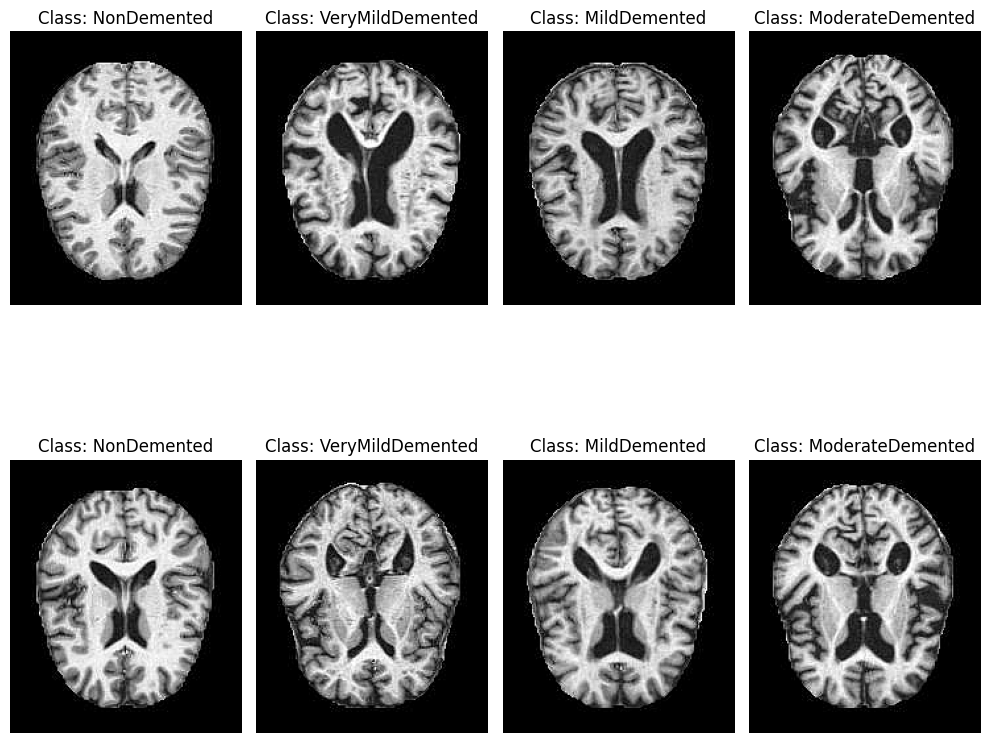

In [23]:
loader = DataLoader(dataset, batch_size=5121, shuffle=True)
images, labels = next(iter(loader))
images,labels=images.cuda(), labels.cuda()

images_per_class = 2

class_indices = {}
for i, label in enumerate(labels):
    label_item = label.item()
    if label_item not in class_indices:
        class_indices[label_item] = [i]
    elif len(class_indices[label_item]) < images_per_class:
        class_indices[label_item].append(i)

fig, axes = plt.subplots(images_per_class, len(class_indices), figsize=(10, 10))
class_names = dataset.classes
for i, (class_index, image_indices) in enumerate(class_indices.items()):
    for j, image_index in enumerate(image_indices):
        img = images[image_index].cpu().numpy().squeeze()  
        axes[j, i].imshow(img, cmap='gray')  
        axes[j, i].axis('off')  
        axes[j, i].set_title(f'Class: {class_names[class_index]}')
plt.tight_layout()
plt.show()


**Number of images per class :**

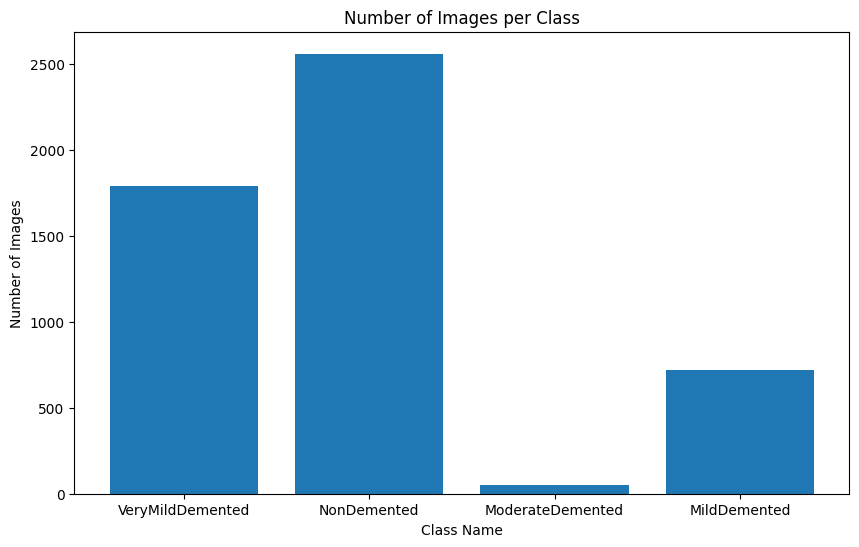

In [24]:
class_names = dataset.classes
class_counts = Counter()
for _, labels in loader:
    class_counts.update(labels.tolist())
class_indices, counts = zip(*class_counts.items())
class_labels = [class_names[i] for i in class_indices]

plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts, align='center')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

**Weigthed cross-entropy loss :**

In [31]:
L=nn.CrossEntropyLoss() 
weights=torch.tensor([717,52,2560,1792],dtype=torch.float32)
weights=5121/weights
WL=nn.CrossEntropyLoss(weight=weights.to(device))

**Evaluation Metrics :**

In [32]:
def loss_compute(dataloader):
    losses=0
    for i, (x, y) in enumerate(dataloader):
        x, y = x.cuda(), y.cuda()
        opt.zero_grad()
        yhat=model(x)
        loss = L(yhat, y)
        loss.backward() 
        opt.step()
        losses+=loss.item()
    loss_value=losses/len(dataloader.dataset)
    return loss_value


def Accuracy(model, dataloader):
    accuracy=0
    model.eval()
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):
            x, y = x.cuda(), y.cuda()
            prediction = model(x).argmax(axis=1)
            accuracy += torch.sum(prediction==y.data)
    accuracy=(accuracy/len(dataloader.dataset))*100
    return accuracy



def F1(model,dataloader):
    model.eval()
    yhat=[]
    ytrue=[]
    f1_scores = []
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):
            x, y = x.cuda(), y.cuda()
            ytrue.extend(y.cpu().numpy())
            yhat.extend(model(x).argmax(dim=1).cpu().numpy())
    for i in range(4):
        true = (torch.tensor(ytrue) == i)
        pred = (torch.tensor(yhat) == i)
        f1 = f1_score(true, pred)
        f1_scores.append(f1)
    return f1_scores

**Training :**

In [36]:
def train_model(dataset,train,validation,model,opt,batch_size):
    best_f1=0
    best_acc=0
    train_loss=[]
    validation_loss=[]
    train_accuracy=[]
    validation_accuracy=[]
    labels = [label for _, label in dataset]
    for epoch in range(70):
        train_data, validation_data= random_split(dataset, [train,validation]) 
        tl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        vl = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
        model.train()
        loss_value=loss_compute(tl)
        train_loss.append(loss_value)
        model.eval()
        validation_loss.append(loss_compute(vl))
        accuracy_train=Accuracy(model,tl)
        train_accuracy.append(accuracy_train)
        accuracy_val=Accuracy(model,vl)
        validation_accuracy.append(accuracy_val)
        f1_scores=F1(model,vl)
        f1=np.mean(f1_scores)
        print(f"Epoch:{epoch} Loss:{loss_value:.6f} Validation accuracy:{accuracy_val:.2f}% Mean of F1 Score:{f1:.6f}")
        if accuracy_val >= best_acc:
            best_acc=accuracy_val
            torch.save(model.state_dict(), 'best_model.pth')
    model.load_state_dict(torch.load('best_model.pth'))
    for epoch in range(70,100):
        train_data, validation_data = train_test_split(dataset, test_size=validation, stratify=labels, random_state=42)
        tl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        vl = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
        model.train()
        loss_value=loss_compute(tl)
        train_loss.append(loss_value)
        model.eval()
        validation_loss.append(loss_compute(vl))
        accuracy_train=Accuracy(model,tl)
        train_accuracy.append(accuracy_train)
        accuracy_val=Accuracy(model,vl)
        validation_accuracy.append(accuracy_val)
        f1_scores=F1(model,vl)
        f1=np.mean(f1_scores)
        print(f"Epoch:{epoch} Loss:{loss_value:.6f} Validation accuracy:{accuracy_val:.2f}% Mean of F1 Score:{f1:.6f}")
        if f1 >= best_f1:
            best_f1=f1
            torch.save(model.state_dict(), 'best_model.pth')
    model.load_state_dict(torch.load('best_model.pth'))
    return train_loss, validation_loss, train_accuracy, validation_accuracy

**Hyperparameters tuning :**

In [15]:
lr=[0.001, 0.0001]
batch=[16,32,64]

best=0
param={}

for lrs in lr:
    for batches in batch:
        print(f"Training with learning rate: {lrs}, batch size: {batches}")
        model=CNN().to(device)
        opt=Adam(model.parameters(),lr=lrs,weight_decay=1e-5)
        train_model(train_dataset, train, validation, model, opt, batches)
        dataloader = DataLoader(dataset, batch_size=batches, shuffle=False)
        acc=Accuracy(model, dataloader)
        if acc > best:
            best = acc
            param = {'lr': lrs, 'batch_size': batches}

print("Best hyperparameters:", param)

Training with learning rate: 0.001, batch size: 16
Training with learning rate: 0.001, batch size: 32
Training with learning rate: 0.001, batch size: 64
Training with learning rate: 0.0001, batch size: 16
Training with learning rate: 0.0001, batch size: 32
Training with learning rate: 0.0001, batch size: 64
Best hyperparameters: {'lr': 0.0001, 'batch_size': 16}


In [34]:
learning_rate=0.0001
batch_size=16
opt=Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

In [37]:
train_loss, validation_loss, train_accuracy, validation_accuracy=train_model(train_dataset,train,validation,model,opt,batch_size)

Epoch:0 Loss:0.054801 Validation accuracy:60.47% Mean of F1 Score:0.360180
Epoch:1 Loss:0.053435 Validation accuracy:64.13% Mean of F1 Score:0.404630
Epoch:2 Loss:0.051432 Validation accuracy:68.57% Mean of F1 Score:0.536697
Epoch:3 Loss:0.050004 Validation accuracy:66.67% Mean of F1 Score:0.605841
Epoch:4 Loss:0.048292 Validation accuracy:75.31% Mean of F1 Score:0.731993
Epoch:5 Loss:0.046362 Validation accuracy:76.33% Mean of F1 Score:0.750125
Epoch:6 Loss:0.044810 Validation accuracy:76.04% Mean of F1 Score:0.704154
Epoch:7 Loss:0.044221 Validation accuracy:73.94% Mean of F1 Score:0.747151
Epoch:8 Loss:0.042882 Validation accuracy:76.82% Mean of F1 Score:0.763336
Epoch:9 Loss:0.041794 Validation accuracy:67.25% Mean of F1 Score:0.605444
Epoch:10 Loss:0.041381 Validation accuracy:81.41% Mean of F1 Score:0.784348
Epoch:11 Loss:0.038245 Validation accuracy:80.38% Mean of F1 Score:0.759579
Epoch:12 Loss:0.037225 Validation accuracy:83.89% Mean of F1 Score:0.826134
Epoch:13 Loss:0.035697

**Description and prediction :**

In [39]:
train_dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=False)
print(f"Training accuracy: {Accuracy(model,train_dataloader)}")

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Test accuracy: {Accuracy(model,test_dataloader)}")

Training accuracy: 100.0
Test accuracy: 83.65911102294922


**Losses and Accuracies Progression :**

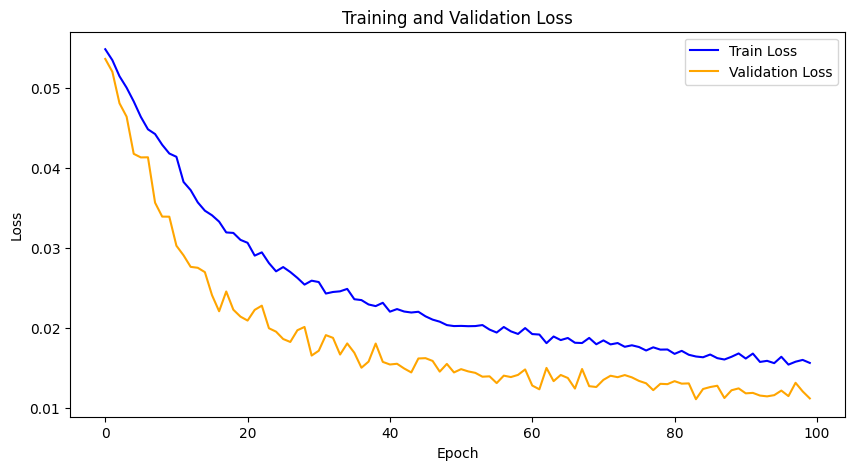

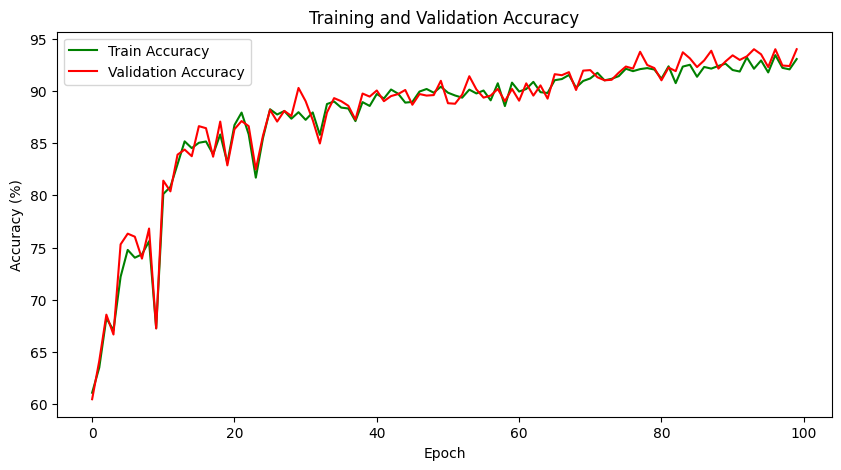

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

train_accuracy= [item.cpu().numpy() for item in train_accuracy]
validation_accuracy = [item.cpu().numpy() for item in validation_accuracy]

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.plot(validation_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(False)
plt.show()

**Confusion Matrix :**

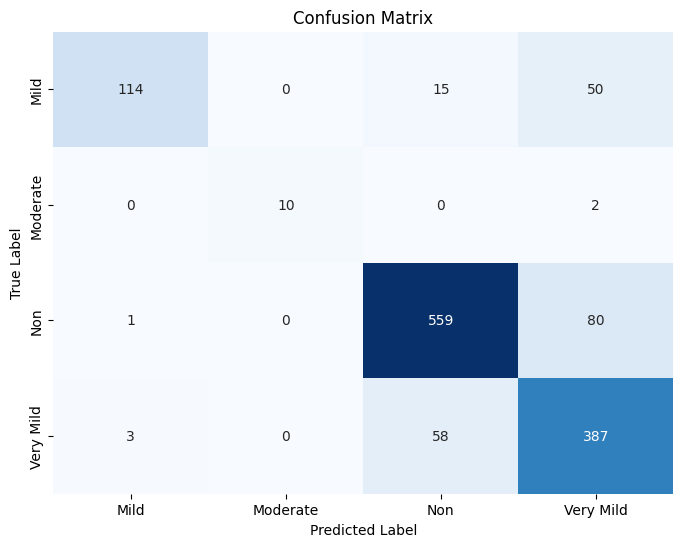

In [41]:
def calculate_confusion_matrix(model, dataloader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images,labels = images.cuda(),labels.cuda()
            _, predicted = torch.max(model(images), 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    cm = confusion_matrix(y_true, y_pred)
    return cm

conf_matrix = calculate_confusion_matrix(model, test_dataloader)
class_names=['Mild','Moderate', 'Non','Very Mild']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Second Training Strategy :

**Data Processing and Augmentation :**

In [6]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=10)
    ],p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=350)
    ],p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ],p=0.2),
    transforms.RandomAffine(degrees=10, scale=[0.9,1.2]), 
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=3,p=0.5),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.RandomAutocontrast(p=1),
    transforms.RandomAdjustSharpness(sharpness_factor=3,p=1),
    transforms.ToTensor()           
])

**Data loading :**

In [7]:
class Augmentation(Dataset):
    def __init__(self, filepath):
        number=3000
        self.image=[]
        self.label=[]
        file_path=filepath+'/'
        file_list=os.listdir(file_path)
        file_number=len(file_list)
        for j in range(file_number):
            image_path=file_path+file_list[j]+'/'
            image_list=os.listdir(image_path)
            image_number=len(image_list)
            aug_number=number-image_number
            it=0
            while it < aug_number:
                for i in range(image_number):
                    image_name=image_path+image_list[i]
                    img=Image.open(image_name)
                    img=augmentation(img)
                    img=img.unsqueeze(0) 
                    self.image.append(img)
                    if file_list[j]== 'MildDemented':
                        self.label.append(0)
                    if file_list[j]== 'ModerateDemented':
                        self.label.append(1)
                    if file_list[j]== 'NonDemented':
                        self.label.append(2)
                    if file_list[j]== 'VeryMildDemented':
                        self.label.append(3)
                    it=it+1
                    if it == aug_number:
                        break
        self.image=torch.cat(self.image,dim=0)
        self.label = torch.tensor(self.label)
        self.label = F.one_hot(self.label,num_classes=4).to(float) 
    def __len__(self):
        return self.image.shape[0]
    def __getitem__(self, i):
        return self.image[i], self.label[i]
    
    
class Dataset(Dataset):
    def __init__(self, filepath):
        self.image=[]
        self.label=[]
        file_path=filepath+'/'
        file_list=os.listdir(file_path)
        file_number=len(file_list)
        for j in range(file_number):
            image_path=file_path+file_list[j]+'/'
            image_list=os.listdir(image_path)
            image_number=len(image_list)
            for i in range(image_number):
                image_name=image_path+image_list[i]
                img=Image.open(image_name)
                img=transform(img)
                img=img.unsqueeze(0) 
                self.image.append(img)
                if file_list[j]== 'MildDemented':
                    self.label.append(0)
                if file_list[j]== 'ModerateDemented':
                    self.label.append(1)
                if file_list[j]== 'NonDemented':
                    self.label.append(2)
                if file_list[j]== 'VeryMildDemented':
                    self.label.append(3)
        self.image=torch.cat(self.image,dim=0)
        self.label = torch.tensor(self.label)
        self.label = F.one_hot(self.label,num_classes=4).to(float) 
    def __len__(self):
        return self.image.shape[0]
    def __getitem__(self, i):
        return self.image[i], self.label[i]
    
    
    
train_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/"
test_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/"    
augmented=Augmentation(train_dir)    
dataset=Dataset(train_dir)


train_dataset=ConcatDataset([augmented, dataset])
train=int(0.8*len(train_dataset))
validation=len(train_dataset)-train
print(len(train_dataset))

12000


**Cross-Entropy Loss :**

In [12]:
L=nn.CrossEntropyLoss() 

**Evaluation Metrics :**

In [8]:
def loss_compute(dataloader):
    losses=0
    for i, (x, y) in enumerate(dataloader):
        x, y = x.cuda(), y.cuda()
        opt.zero_grad()
        yhat=model(x)
        loss = L(yhat, y)
        loss.backward() 
        opt.step()
        losses+=loss.item()
    loss_value=losses/len(dataloader.dataset)
    return loss_value

def Accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, predicted = torch.max(model(images), 1)
            total += labels.size(0)
            if labels.dim() > 1:
                y = labels.argmax(dim=1)
            else:
                y = labels
            correct += (predicted == y).sum().item()
    accuracy = (correct / total) * 100
    return accuracy

**Training :**

In [9]:
def train_model(dataset,train,validation,model, opt, batch_size):
    best_acc=0
    count=0
    patience=10
    train_loss=[]
    validation_loss=[]
    train_accuracy=[]
    validation_accuracy=[]
    for epoch in range(100):
        train_data, validation_data= random_split(dataset, [train,validation]) 
        tl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        vl = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
        model.train()
        loss_value=loss_compute(tl)
        train_loss.append(loss_value)
        model.eval()
        validation_loss.append(loss_compute(vl))
        accuracy_train=Accuracy(model,tl)
        train_accuracy.append(accuracy_train)
        accuracy_val=Accuracy(model,vl)
        validation_accuracy.append(accuracy_val)
        print(f"Epoch:{epoch} Loss:{loss_value:.6f} Validation accuracy:{accuracy_val:.2f}%")
        if accuracy_val > best_acc:
            best_acc=accuracy_val
            count=0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            count+=1
            if count >= patience:
                print("Early Stopping")
                break
    model.load_state_dict(torch.load('best_model.pth'))
    return train_loss, validation_loss, train_accuracy, validation_accuracy

**Hyperparameters tuning :**

In [30]:
lr=[0.001, 0.0001]
batch=[16,32,64]

best=0
param={}

for lrs in lr:
    for batches in batch:
        print(f"Training with learning rate: {lrs}, batch size: {batches}")
        model=CNN().to(device)
        opt=Adam(model.parameters(),lr=lrs,weight_decay=1e-5)
        train_model(train_dataset, train, validation, model, opt, batches)
        dataloader = DataLoader(dataset, batch_size=batches, shuffle=False)
        acc=Accuracy(model, dataloader)
        if acc > best:
            best = acc
            param = {'lr': lrs, 'batch_size': batches}

print("Best hyperparameters:", param)

Training with learning rate: 0.001, batch size: 16
Training with learning rate: 0.001, batch size: 32
Training with learning rate: 0.001, batch size: 64
Training with learning rate: 0.0001, batch size: 16
Training with learning rate: 0.0001, batch size: 32
Training with learning rate: 0.0001, batch size: 64
Best hyperparameters: {'lr': 0.001, 'batch_size': 64}


In [10]:
learning_rate=0.001
batch_size=64
opt=Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

In [13]:
train_loss, validation_loss, train_accuracy, validation_accuracy=train_model(train_dataset,train,validation,model,opt,batch_size)

Epoch:0 Loss:0.017770 Validation accuracy:52.96%
Epoch:1 Loss:0.015405 Validation accuracy:64.25%
Epoch:2 Loss:0.014001 Validation accuracy:63.88%
Epoch:3 Loss:0.013315 Validation accuracy:66.42%
Epoch:4 Loss:0.012287 Validation accuracy:66.12%
Epoch:5 Loss:0.011757 Validation accuracy:76.17%
Epoch:6 Loss:0.010746 Validation accuracy:76.83%
Epoch:7 Loss:0.010172 Validation accuracy:76.50%
Epoch:8 Loss:0.010163 Validation accuracy:83.12%
Epoch:9 Loss:0.009134 Validation accuracy:85.04%
Epoch:10 Loss:0.008930 Validation accuracy:88.79%
Epoch:11 Loss:0.008297 Validation accuracy:85.83%
Epoch:12 Loss:0.008176 Validation accuracy:87.96%
Epoch:13 Loss:0.007647 Validation accuracy:92.00%
Epoch:14 Loss:0.007180 Validation accuracy:91.96%
Epoch:15 Loss:0.006985 Validation accuracy:87.75%
Epoch:16 Loss:0.006762 Validation accuracy:91.62%
Epoch:17 Loss:0.006533 Validation accuracy:92.92%
Epoch:18 Loss:0.006382 Validation accuracy:94.62%
Epoch:19 Loss:0.005986 Validation accuracy:91.33%
Epoch:20 L

**Description and prediction :**

In [14]:
train_dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=False)
accuracy=Accuracy(model,train_dataloader)   
print(f"Training accuracy: {accuracy}")

test_dataset = Dataset(test_dir)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
accuracy=Accuracy(model,test_dataloader)
print(f"Test accuracy: {accuracy}")

Training accuracy: 100.0
Test accuracy: 76.93510555121188


**Losses and Accuracies Progression :**

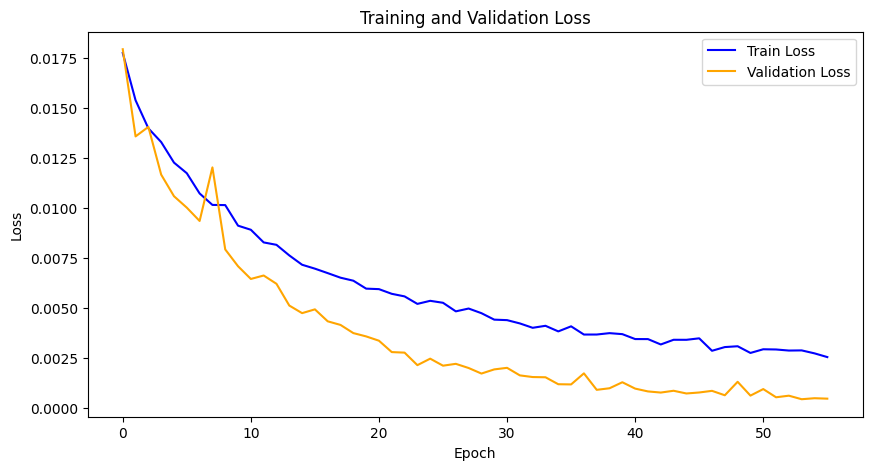

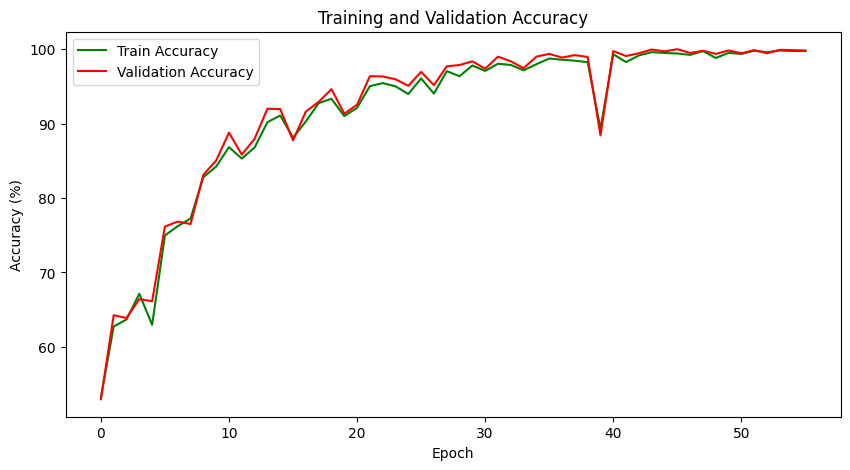

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.plot(validation_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(False)
plt.show()

**Confusion Matrix :**

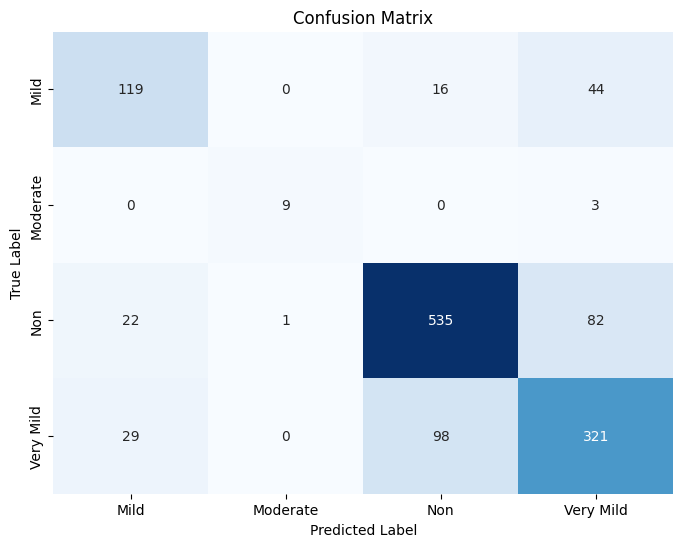

In [16]:
def calculate_confusion_matrix(model, dataloader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            _, predicted = torch.max(model(images), 1)
            y_true.extend(labels.cpu().argmax(dim=1).tolist())  
            y_pred.extend(predicted.cpu().tolist())  
    cm = confusion_matrix(y_true, y_pred)
    return cm

conf_matrix = calculate_confusion_matrix(model, test_dataloader)
class_names=['Mild','Moderate', 'Non','Very Mild']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()